In [1]:
import json
import numpy as np
import glob
import os
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd
import json

from sklearn.metrics import pairwise_distances

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu

# from dredFISH.Design.model_v2p2_gene_constraints import CellTypeNet
from dredFISH.Design import data_loader_scrna 

config = importlib.import_module("dredfish_processing_config")

importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [3]:
for i, bit in enumerate(config.bitmap):
    print(i, bit)

0 ('RS0109_cy5', 'hybe2', 'FarRed')
1 ('RS0175_cy5', 'hybe3', 'FarRed')
2 ('RS0237_cy5', 'hybe4', 'FarRed')
3 ('RS0307_cy5', 'hybe5', 'FarRed')
4 ('RS0332_cy5', 'hybe6', 'FarRed')
5 ('RS0384_atto565', 'hybe10', 'FarRed')
6 ('RS0406_atto565', 'hybe11', 'FarRed')
7 ('RS0451_atto565', 'hybe12', 'FarRed')
8 ('RS0468_atto565', 'hybe13', 'FarRed')
9 ('RS0548_atto565', 'hybe14', 'FarRed')
10 ('RS64.0_atto565', 'hybe15', 'FarRed')
11 ('RS156.0_alexa488', 'hybe19', 'FarRed')
12 ('RS278.0_alexa488', 'hybe20', 'FarRed')
13 ('RS313.0_alexa488', 'hybe21', 'FarRed')
14 ('RS643.0_alexa488', 'hybe22', 'FarRed')
15 ('RS740.0_alexa488', 'hybe23', 'FarRed')
16 ('RS810.0_alexa488', 'hybe24', 'FarRed')
17 ('RSN9927.0_cy5', 'hybe7', 'FarRed')
18 ('RSN2336.0_cy5', 'hybe8', 'FarRed')
19 ('RSN1807.0_cy5', 'hybe9', 'FarRed')
20 ('RSN4287.0_atto565', 'hybe16', 'FarRed')
21 ('RSN1252.0_atto565', 'hybe17', 'FarRed')
22 ('RSN9535.0_atto565', 'hybe18', 'FarRed')
23 ('RS0095_cy5', 'hybe1', 'FarRed')
24 ('PolyT', 'hyb

In [4]:
pmat_cols = [bit[0].split('_')[0] for bit in config.bitmap[:24]]
pmat_cols

['RS0109',
 'RS0175',
 'RS0237',
 'RS0307',
 'RS0332',
 'RS0384',
 'RS0406',
 'RS0451',
 'RS0468',
 'RS0548',
 'RS64.0',
 'RS156.0',
 'RS278.0',
 'RS313.0',
 'RS643.0',
 'RS740.0',
 'RS810.0',
 'RSN9927.0',
 'RSN2336.0',
 'RSN1807.0',
 'RSN4287.0',
 'RSN1252.0',
 'RSN9535.0',
 'RS0095']

In [5]:
# the dataset
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=5000,
)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
genes_data = tst_dataloader.dataset.data['genes'][:] #.Genes
genes_cnst = genes_data[cnstrnts_idx]
print(genes_data.shape, genes_cnst.shape)

(45768,) (23282,)


In [6]:
%%time
# validation dataset
ftrs_all, clsts = next(iter(tst_dataloader))
ftrs_all = ftrs_all.float()#.numpy() # all features
clsts = clsts.long().numpy()

CPU times: user 2min 37s, sys: 21.5 s, total: 2min 58s
Wall time: 25.8 s


In [7]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts)]

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
l3clst_order = np.array(meta['l3_clsts']) # get cluster order

_rows_l3clsts = basicu.get_index_from_array(type_orders, l3clst_order)

l3clst_order.shape, type_orders.shape, _rows_l3clsts

((42,),
 (42,),
 array([34, 38, 39, 41, 37, 28, 29, 11, 17, 18, 24,  6, 10,  9, 12, 13, 14,
        15, 21, 25, 23,  5, 26, 27, 22, 31, 32, 16, 19, 20, 36,  1,  2,  3,
         7,  4,  0,  8, 30, 35, 40, 33]))

In [8]:
# get the NN genes and constraints (for DPNMF design)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
nngenes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/probe_constraints.npy'
nngene_cnstrnts = np.load(f)
assert len(nngene_cnstrnts) == len(nngenes)
print(nngene_cnstrnts.shape)

(10861,)


In [9]:
# get new set genes and constraints
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/pshop_smart_l5n100_cpm1_genes.txt' 
newgenes = np.loadtxt(f, dtype=str)
newgene_cnstrnts = cnstrnts[basicu.get_index_from_array(genes_cnst, newgenes)].numpy()
newgenes.shape, newgene_cnstrnts.shape

((10186,), (10186,))

In [10]:
newgenes

array(['0610009B22Rik', '0610009L18Rik', '0610010F05Rik', ..., 'Zyx',
       'Zzef1', 'Zzz3'], dtype='<U14')

In [11]:
a = genes_cnst
a_cnst = cnstrnts
a, a_cnst

(array(['0610005C13Rik', '0610009B22Rik', '0610009E02Rik', ..., 'Zzef1',
        'Zzz3', 'a'], dtype='<U28'),
 tensor([ 23,  11,   9,  ..., 237,  93,  11]))

In [12]:
b = nngenes
b_cnst = nngene_cnstrnts
b, b_cnst

(array(['Zfy1', 'Kdm5d', 'Eif2s3y', ..., 'Myt1', 'Pcmtd2', 'Polr3k'],
       dtype='<U28'),
 array([ 36, 250,  59, ..., 199, 124,  92]))

In [13]:
genes_comm = np.intersect1d(a, b)
ac_idx = basicu.get_index_from_array(a, genes_comm)
bc_idx = basicu.get_index_from_array(b, genes_comm)
print(genes_comm.shape, a.shape, b.shape)

(10846,) (23282,) (10861,)


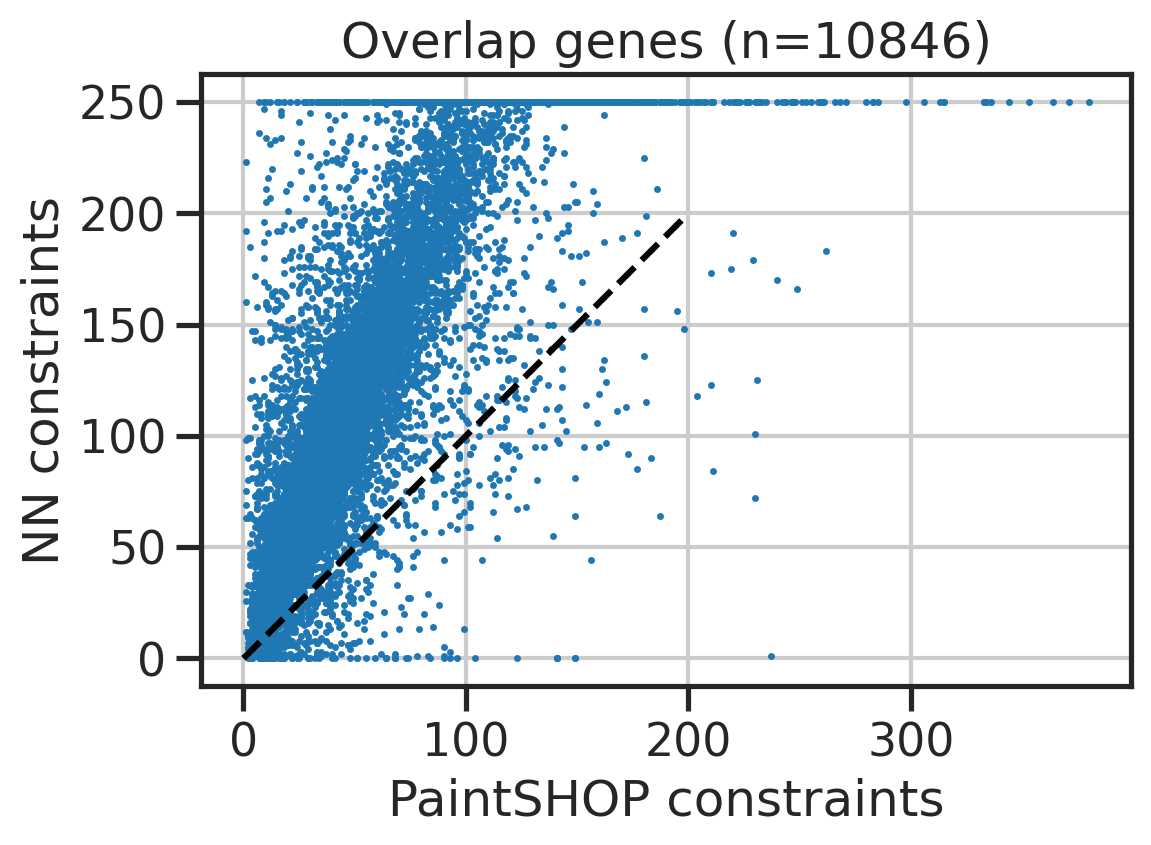

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(a_cnst[ac_idx], 
           b_cnst[bc_idx],
           s=1,
           )
ax.plot([0, 200], [0, 200], '--k') #, color='gray')
ax.set_aspect('equal')
# ax.set_yticks(ax.get_xticks())
ax.set_xlabel('PaintSHOP constraints')
ax.set_ylabel('NN constraints')
ax.set_title(f'Overlap genes (n={len(genes_comm)})')
plt.show()
         